- Java thread is an execution path
- thread actions are implemented using `run` of `Runnable` interface
- scheduling to run via `start` method of thread class
- Thread schedule allocates portions of CPU time via _Thread Scheduler_
- _Java threads time-slice hardware threads (processors) provided by the the CPU cores and can be interrupted at 
any time to give way to another thread_
- if less CPUs then threads
    - time sharing between threads (stop + let other thread execute)
    - order of thread execution is not predictable (stochastic)
- anology
    - cars = threads
    - physical roads = CPU cores
    - if more cars then roads, then time-sharing (or road-sharing)


<img src=attachment:image.png width=400></img>
<img src=attachment:image-2.png width=600></img>
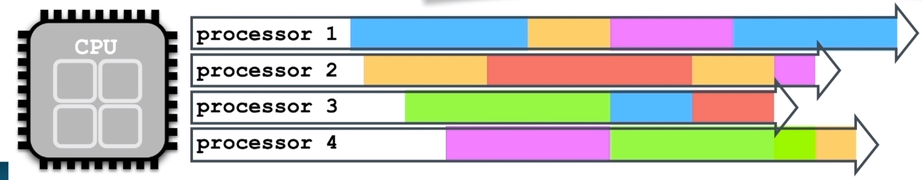
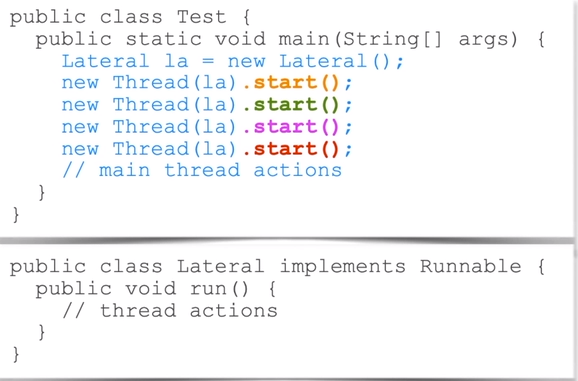

## Implements Runnable
- common practice > _recommmended_
- note: it's a functional interface -> it requests to implement on abstract method

In [1]:
//  ----------------+
//                  v
class HiSayer implements Runnable {
    public void run() {
        System.out.println("hi");
    }
}

In [2]:
Thread t = new Thread(new HiSayer());
t.start();

hi

## Runnable Via Lambda
- good for small amount of actions

In [3]:
Runnable r = () -> System.out.println("Via Lambda");
Thread t = new Thread(r);
t.start();

Via Lambda

## Extends Thread
- use Thread abstract class
- already implements `Runnable`
- not a flexible design > _not recommended_

In [4]:
//  --------------------+
//                      v
public class MuhSayer extends Thread {
    public void run() {
        System.out.println("muh");
    }
}

Thread t = new MuhSayer();
t.start();

muh

## Thread Life Cycle
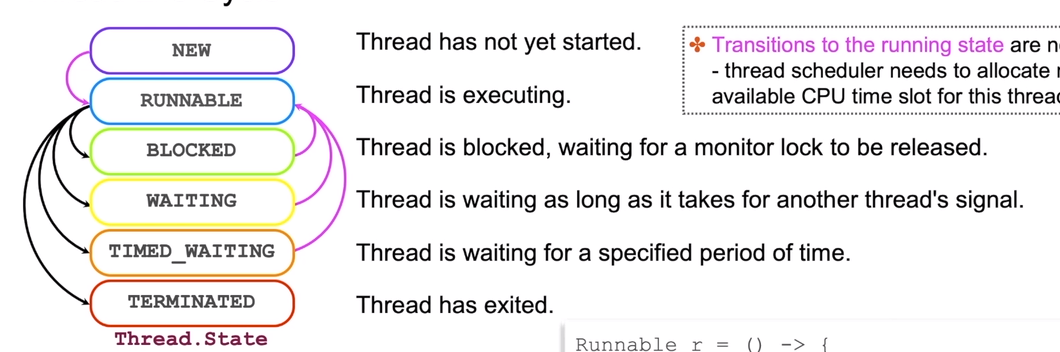

- you can only go from "new" to "runnable"
- from "runnable" all later states can be reached
- most of the later states can return to "runnable"


- same `Runnable` can be processed by multiple threads (parallel processing)
- life cycle phases can be checked
- same thread _can't start twice_

In [5]:
import java.util.concurrent.atomic.*;

In [6]:
AtomicBoolean firstRun = new AtomicBoolean(true);

public void sleep(long millis) {
    try {
        Thread.sleep(millis);    
    } catch (Exception e) {
    // swallowed
    }
}


Runnable r = () -> {
    
    if (firstRun.get()) {
        firstRun.set(false);    
        System.out.println("first run");
        sleep(100);
    }
    
    sleep(500);
    System.out.println("inside");
};

Thread t1 = new Thread(r);
Thread t2 = new Thread(r);
t1.start();
t2.start();
System.out.println("t1 alive: " + t1.isAlive());
System.out.println("t2 alive: " + t2.isAlive());

System.out.println("t1 state: " + t1.getState());
System.out.println("t2 state: " + t2.getState());
sleep(400);
System.out.println("t1 state: " + t1.getState());
System.out.println("t2 state: " + t2.getState());

first run
t1 alive: true
t2 alive: true
t1 state: TIMED_WAITING
t2 state: TIMED_WAITING
inside
inside
t1 state: TERMINATED
t2 state: TERMINATED


## Interrupt Thread Via Signal
- logic inside `run` is in charge of the life cycle decisions
- a thread in _runnable_ state _may_ check if it has received an interrupt signal
- a thread in _waiting_ or _timed waiting_ state 
    - _must_ catch `InterruptedException`
    - puts it back into _runnable_ state (wakeup) and runs the according logic (catch block of the exception)    

In [7]:
Runnable r = () -> {
    Thread currentThread = Thread.currentThread();
    while (!currentThread.isInterrupted()) {
        try {
            Thread.sleep(1000);   // enter TIMED_WAITING for 1 sec
        } catch (InterruptedException e) {
            System.out.println("woke up - terminating");
            return;
        }
    }
};
Thread t = new Thread(r);
t.start();
//sleep(100);
System.out.println(t1.getState());
t.interrupt();

TERMINATED

woke up - terminating

- reacting to `interrupt` signal 
    - while in `RUNNABLE` state via `ct.isInterrupted()`
    - while in `TIMED_WAITING` `sleep` is interrupted and throws the `InterruptedException`


## Block Thread
- helps to coordinate order of execution of threads
- _monitor object_ - helps to coordinate execution order of threads
- anology
    - monitor object = traffic light
    - thread itself turns traffic light red ("I wanna be blocked")
- thread that first enters synchronized block remains in RUNNABLE state
- all other threads wait unti block is released
- then next thread enters RUNNABLE

In [8]:
// note: synchronized on method level lead to syntax error, possible not supported by jshell?
public class SynchronizedTest {
    
    private AtomicInteger cnt = new AtomicInteger(0);

    public void miau() {
        System.out.println("Thread no " + cnt.incrementAndGet());
        /*   TODO understand why I dont see all 3 threads output when sleep is turned on
        try {
            Thread.sleep(100);
        } catch (InterruptedException e) {
            System.out.println("interrupted");  // should be not called
        }
        */
    }
    
}

SynchronizedTest s = new SynchronizedTest();
Runnable r = () -> {
    synchronized (s) {
        s.miau();
    }
};

new Thread(r).start();
new Thread(r).start();
new Thread(r).start();

Thread no 1
Thread no 2

Thread no 3

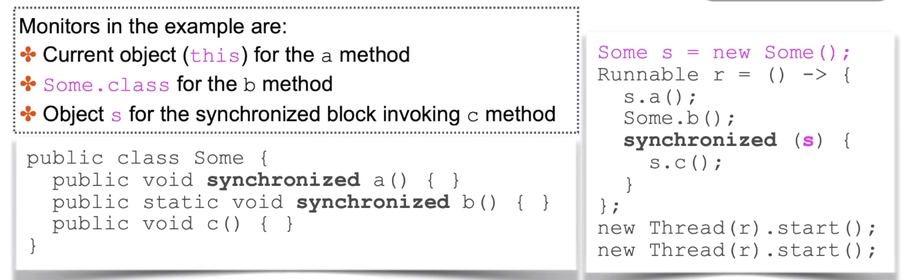

- `a()` - only threads sharing the same instance of the class block each other. Threads on an other instance form a new thread group
- `b()` - any thread using Some.b() will block
- `c()` - guessing. similar to `a()` but for the whole instance. Access to `s` is blocked, not only to `s.a()`

## Make Thread Wait Until Notified
- suspend thread waiting indefinetly
- `wait` puts thread into waiting state against specific monitor
- any number of threads can be waiting against the same monitor
- `notify` wakes up _one_ of the waiting threads (random)
- `notifyAll` wakes up _all_ waiting threads


Note: `wait/notify/notifyAll` must be invoked within `synchronized` blocks against the same monior



In [9]:
// TODO understand why (4) is not printed
Object monitor = new Object();

Runnable r = () -> {
    try {
        synchronized (monitor) {
            System.out.println("(2) Entering waiting state");
            monitor.wait();
        }
    } catch (InterruptedException e) {
        System.out.println("(4) Got notifed");
    }
};

Thread t = new Thread(r);
System.out.println("(1) Starting thread");
t.start();
sleep(500);

System.out.println("(3) Notifying thread");
synchronized (monitor) {
    monitor.notify();
}
System.out.println("(5) Done");

(1) Starting thread
(2) Entering waiting state
(3) Notifying thread
(5) Done


## Thread Properties

In [10]:
Runnable r = () -> { /* nop */ };

### Custom Name

In [11]:
new Thread(r, "My Thread").getName()

My Thread

## Daemon or User 
- by default a thread is marked as `user`
- does not exit when main thread is done
- setting thread to daemon (`t.setDaemon(true)`) tells JVM to exit anyway even if thread is still running
- think of background task which are not business critical (e.g. logging)
- must be invoked before starting the thread

### Setting Priorities
- `t.setPriority(3)`
- depends on the platfirm 
- determines the number of CPU times slots the thread scheduler allocates to this thread
- cannot guarantee order of execution

In [12]:
Thread.MIN_PRIORITY

1

In [13]:
Thread.MAX_PRIORITY

10

In [14]:
Thread.NORM_PRIORITY

5

### join threads
- wait for other thread to terminate


_When we invoke the join() method on a thread, the calling thread goes into a waiting state. It remains in a waiting state until the referenced thread terminates._

In [15]:
Runnable r = () -> {
    System.out.println("(2) Inside job");
    sleep(500);
};

System.out.println("(1) Starting thread");
Thread t = new Thread(r);
t.start();
System.out.println("(3) Waiting for finish");
t.join();  // optionally with max wait time
System.out.println("(4) Done");

(1) Starting thread
(2) Inside job
(3) Waiting for finish
(4) Done


# Executors
- simplify thread management
- there are different `ExecutorService` objects

| Name        |  Description               |
|-------------|----------------------------|
|Fixed Thread Pool | resuses fixed numer of threads |
| Work Stealing Pool | mantains enough threads to support the given parallelism level |
| Single Thread Executor | uses single worker thread | 
| Cached Thread Pool | creates new threads as needed or reuses existing threads |
| Scheduled Thread Pool | schedules taks to execute with a delay and/ or periodically |
| Single Thread Scheduler Executor | schedules taks to execute with a delay using single worker thread »
| Unconfgurable Executor Service | provides a way to "freeze" another Executur Service configuration |


### Important Methods
- `void Executor.execute(Runnable)`
- `Future<T> ExecutorService.<T>submit(Callable<T>)` - also variants which support `Runnable`
- `void ExecutorService.shutdown()` - stop accepting tasks (does _not_ shutdown int pool!)
- `boolean ExecutorService.awaitTermination(long, TimeUnit)` - blocks for max given time
- `List<Runnable> ExecutorService.shutdownNow()` - terminates the pool, returns list of still running tasks

### Execute task

In [16]:
import java.util.concurrent.*;

In [17]:
Runnable r = () -> System.out.println("hi");
ExecutorService es = Executors.newSingleThreadExecutor();
// no return value
es.execute(r);
es.shutdown();

hi


### Submit Task To Obtain a Future

In [18]:
Callable c = () -> {
    sleep(500);
    return "i am done";
};

ExecutorService es = Executors.newSingleThreadExecutor();
// returns a future
Future<String> result = es.submit(c);

System.out.println(result.isDone());
sleep(500);
System.out.println(result.isDone());
System.out.println(result.get());
es.shutdown();

false
true
i am done


### Schedule Example

In [19]:
import java.nio.*;
import java.nio.file.*;

In [20]:
Path tmpFile = Path.of("/tmp/output");
AtomicInteger cnt = new AtomicInteger(0);

Runnable t = () -> {
    try {
        Files.writeString(tmpFile, String.valueOf(cnt.incrementAndGet()) + "\n", 
            StandardOpenOption.CREATE, StandardOpenOption.APPEND);
    }
    catch (IOException e) {
        System.err.println(e);
    }
};

Files.deleteIfExists(tmpFile);
// pool of 3 threads
ScheduledExecutorService ses = Executors.newScheduledThreadPool(3);
// run task after 100 ms inital wait, then every 200 ms
ses.scheduleAtFixedRate(t, 100, 200, TimeUnit.MILLISECONDS);
// create an an unmodifiable Executor Servcie (e.g. to pass it to an external user)
ExecutorService es = Executors.unconfigurableScheduledExecutorService(ses);

sleep(1000);
es.shutdown();
Files.readAllLines(tmpFile);

[1, 2, 3, 4, 5]

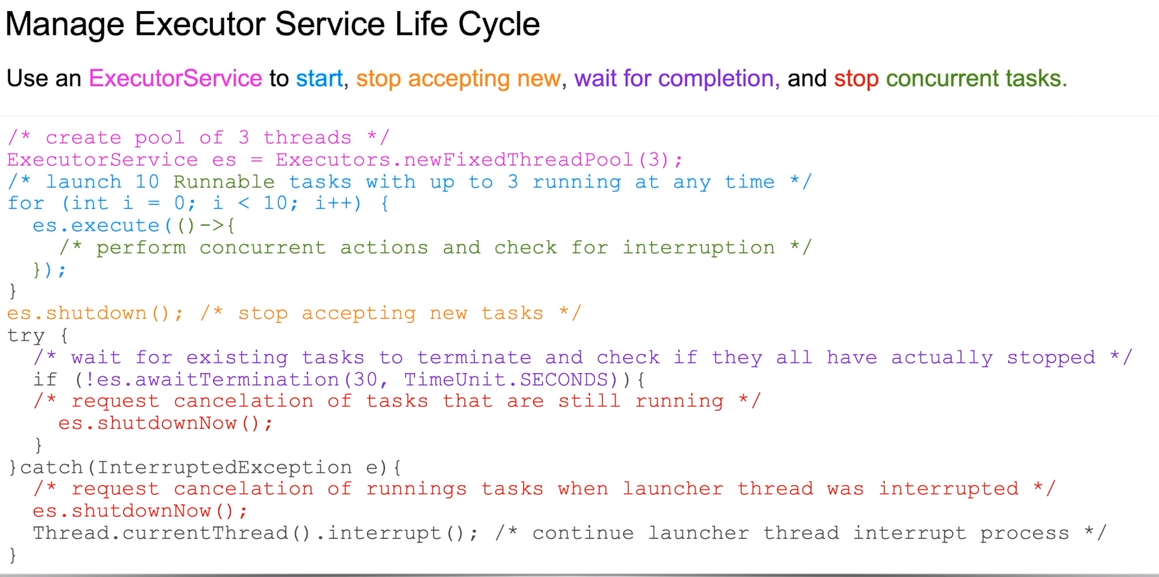

## Locking Problems
- hard to troubleshoot & debug
- hardly reproducable in different environment and depends on many factors like
    - load
    - CPU available
    - memory
    - ...

### Starvation
- synchronized block of code which is entered by the thread A
- thread B using the same monitor object will wait until A is done 
- can take very long

### Livelock
- two threads asking constantly "Are you finished?"
- form an indefinite loop
- In fron of a door: "After you" - "No, after you" - "No, after you" ...

### Deadlock
- using different object monitors for synchronized blocks in reverse order
- example:
    - first thread is entering synchronized block on monitor _a_ and waits to enter synchronized block _b_
    - second thread entered synchronized block on monitor _b_ and waits to enter synchronized block _a_
- always a reverse order is involved
- they wait forever, program stops

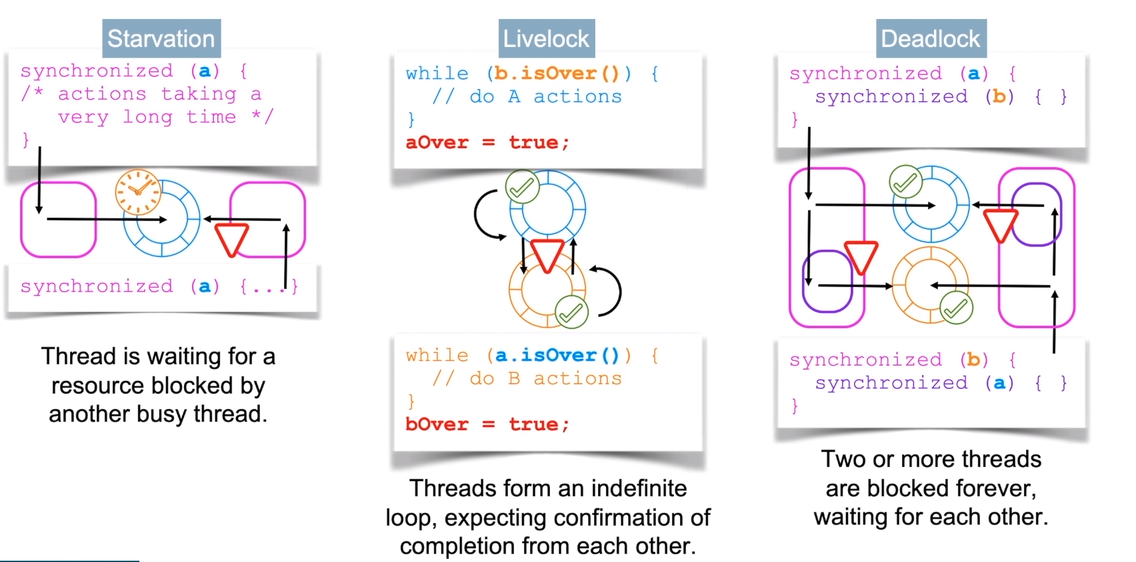

## Avoding Them
- accept stochastic nature of threads
- don't try to force a certain order
- immutable design
- work with copies or read-only views

## Writing Thread-Safe Code

- stack values
    - local vars, method arguments
    - _are thread-safe_
    - local to the current thread

- heap is potentially shared
    - immutable objects on the heap are thread-safe (no mutation)
    - issues is with _mutable heap objects_ > thread-unsafe


- potential error scenarios
    - inconsistant - observed by other thread before modification is complete
    - corrupted - partially changed by another thread writing at the same time
    - compiler could cache heap values locally within a thread > thread does not notice that data has been changed by another thread

### Volatile keyword
- disable caching of a heap variable locally in the stack
- always read from the heap

<img src=attachment:image.png width=500></img>
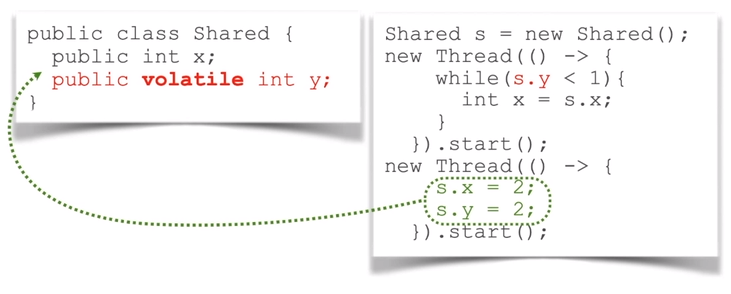

Example:
- `while` loop could become indefinite if compiler decides to cache variable `y` locally
- setting `y` to `volatile` ensures that the value is always accessed at its source in the heap
- slightly slows down the program 

## Atomic Action
_Can be performed in a single CPU cycle without being interrupted_

- cannot be interleaved (verschachtelt)
- default atomic action
    - performed by a single CPU
    - in a single cycle
- variable asssignments
    - are atomic
    - exceptions: `long` and `double`
        - 64 bit values
        - on a 32 bit platform it takes more than 1 CPU cycle to assign them
- _non-atomic_ operations (example): `+ - / * % ++ --`
- `java.utlil.concurrent.atomic` provides classes for lock-free thread-safe programming of atomic behaviour of single variables
    - `AtomicBoolean`
    - `AtomicInteger`
    - `AtomicLong`
    - `AtomicReference<V>`
    - ...
- behave as if they are volatile

Alternative to `synchronize` every arithmatic block -> leads to deadlocks

In [53]:
public class Shared {
    public AtomicInteger x = new AtomicInteger(0);
}

Shared s = new Shared();
Runnable r = () -> {
    int y = 0;
    while(y < 10) {
        y = s.x.incrementAndGet();
        System.out.println("shared 'x' is " + s.x.get() + ", thread name: " + Thread.currentThread().getName());
        // stochastic execution time (0-100 ms)
        sleep(Math.round(Math.random()*100));
    }
};
Thread t1 = new Thread(r, "Hugo");
t1.start();
Thread t2 = new Thread(r, "Berd");
t2.start();
t2.join();
System.out.println("Done")


shared 'x' is 1, thread name: Hugo
shared 'x' is 2, thread name: Hugo
shared 'x' is 3, thread name: Berd
shared 'x' is 4, thread name: Berd
shared 'x' is 5, thread name: Hugo
shared 'x' is 6, thread name: Hugo
shared 'x' is 7, thread name: Berd
shared 'x' is 8, thread name: Hugo
shared 'x' is 9, thread name: Berd
shared 'x' is 10, thread name: Hugo
shared 'x' is 11, thread name: Berd
Done


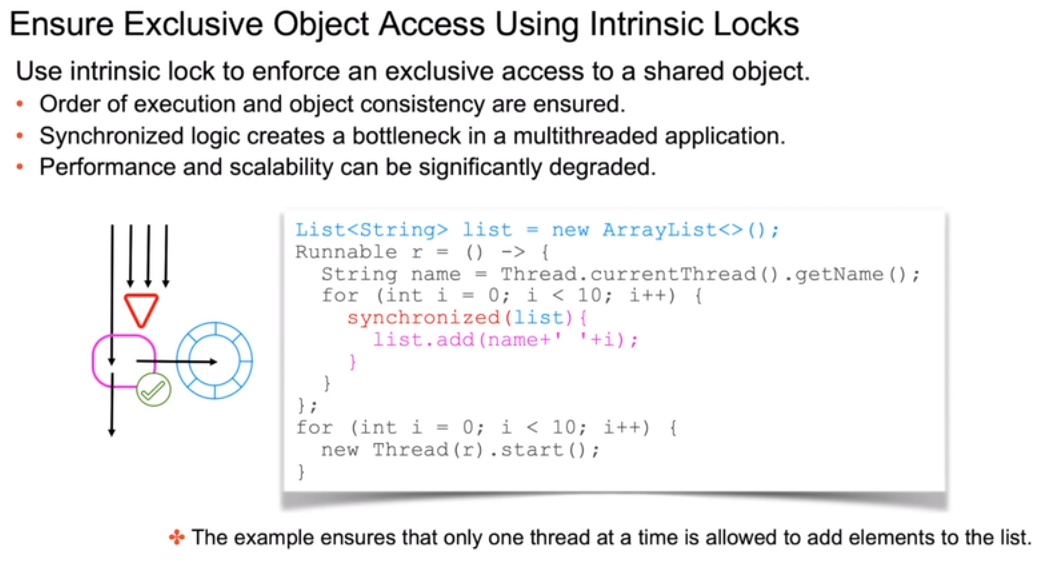

- guarantees that `list.add` is only called by one thread at a time

## Intrinsic Lock Automation
- use `synchronized` version of a collection
- writing is guaranteed to be thread safe
- reading from the list requires `synchronized` 
    - supposed to avoid reading half-written data

In [55]:
import java.util.stream.*;

In [106]:
List<String> list = new ArrayList<>();
List<String> slist = Collections.synchronizedList(list);
var writer = new Thread(() -> {
        IntStream.rangeClosed(0, 10).forEach(i -> {
            String name = Thread.currentThread().getName();
            slist.add(i, name);
            sleep(50);
        });
}, "Ronny");
writer.start();

// read is not automatically synchronized
// run in a synchronized block to ensure consistency
synchronized(slist) {
    Iterator iterator = slist.iterator();
    while (iterator.hasNext()) {
        String item = (String)iterator.next();        
        System.out.println(item);
        sleep(50);
    }    
}

writer.join();

Ronny


## Non-Blocking Concurrency Automation
- using `CopyOnWriteArrayList` or `CopyOnWriteArraySet`
- all mutations of the list make fresh copy exclusive for the current thread
- to read a read-only snapshot of merged content is created
- issue: memory consumption (copy for each thread)
- best suited for 
    - small collecitons with
    - many ready
    - little writes
    
<img src=attachment:image.png width=300></img>

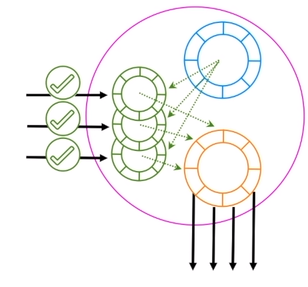

In [109]:
List<String> list = new ArrayList<>();
List<String> copyOnWriteList = new CopyOnWriteArrayList(list);
var writer = new Thread(() -> {
        IntStream.rangeClosed(0, 10).forEach(i -> {
            String name = Thread.currentThread().getName();
            copyOnWriteList.add(i, name);
            sleep(50);
        });
}, "Ronny");
writer.start();

Iterator iterator = copyOnWriteList.iterator();
while (iterator.hasNext()) {
    String item = (String)iterator.next();        
    System.out.println(item);
    sleep(50);
}    

writer.join();

Ronny


## Alternative Locking Mechanisms
- `java.util.concurrent.locks`
- allows actions to be performed on an object, without interference from other threads
- write lock
    - prevents other threads from concurrently modifying the object
- read lock
    - can be acquired if write lock is not held by another thread
    - pause when some other thread is currently writing -> ensures consistency
    - allows concurrent read actions


### Reentrant Locks

In [110]:
import java.util.concurrent.locks.*;

In [176]:
List<String> someDates = new ArrayList<>();

ReentrantReadWriteLock rwLock = new ReentrantReadWriteLock();
Lock readLock = rwLock.readLock();
Lock writeLock = rwLock.writeLock();
Random random = new Random();

public String getRandomEntry() {
    readLock.lock();
    try {
        int randomIndex = 0;
        if (someDates.size() > 1) {
            randomIndex = random.nextInt(someDates.size()-1);
        }
        return someDates.get(randomIndex);
    // note the use of finally to guarantee calling "unlock"
    } finally {
        readLock.unlock();
    }
}    


public void addEntry(String timestamp) {
    writeLock.lock();
    try {
        someDates.add(timestamp);
    } finally {
        writeLock.unlock();
    }
}

In [189]:
import java.time.*;
import java.util.concurrent.*;

Runnable writeTask = () -> {
    addEntry(ZonedDateTime.now().toString());
    //sleep(Math.round(Math.random()*50));
};

Runnable readTask = () -> {
    getRandomEntry();
    //sleep(Math.round(Math.random()*50));
};

In [192]:
var executor = Executors.newFixedThreadPool(20);
IntStream.rangeClosed(1, 30).forEach(i -> {
    executor.execute(writeTask);
    executor.execute(readTask);
});

executor.awaitTermination(3, TimeUnit.SECONDS);
executor.shutdownNow();
someDates.size();

360